# Processing TROPOSIF Data

Author: James Yoon (jyyoon@uw.edu)

---

Last updated: 22 May 2025

This script reads in TROPOSIF data through two different methods. 

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

# More uncommon imports -- make sure you have satellite_processing_functions.py in the same directory
import netCDF4 as nc
import geopandas as gpd
from satellite_processing_functions import convert_to_string, new_grid, read_scattered_TROPOMI_data, regrid_scattered_data
import shapely

# Mapping functions -- not required to process the data, but nice to plot as a sanity check!
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Arial"

def basemap():
    # Creates a fig and ax object with a map of the globe using the Cartopy library
    fig = plt.figure(figsize=(10,5));
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree()); # Can change the projection using different ccrs.__()
    color = 'gray' # Color of the map lines

    # Add in the coastlines, states, and country borders with 50 m resolution.
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor = color);

    return fig, ax;

---

# Method 1: Scattered Data with TROPOMI Footprints

This is the method to use when you want to plot the original TROPOMI footprints, since they aren't points but rather polygons covering a geographic swath. This is also useful if you want to do some downscaling later on!  However, it can be unwieldy to use when doing geographic analysis over >= 1 month, so you might want to do the other method and grid the data for longer-term analysis. 

#### Step 1: Specify file path of the TROPOMI files

fns is a glob array containing the filenames of any TROPOMI datasets containing the filename prefix "S5P_OFFL_L2__SO2____"). We loop through this array to read in all the files. Make sure you change the prefix to fit your computer system.

In [5]:
data_type = 'SIF' # Specifies NO2!
prefix = '/home/disk/hermes/jyyoon/TROPOSIF'
geolocation_bounds = [-126.760254,44.402392,-115.026855,49.282140] # [-132.099609,46.709736,-121.420898,50.485474] # in [lon_min, lat_min, lon_max, lat_max], if you want an entire scanline, remove bounds = geolocation_bounds in the function call below or set this to 0

year_num = np.array([2021]) # Specify the years of interest.
month_num = np.array([6]) # Specify the months (by number, e.g. January = 1)
day_num = np.array([27]) # Specify a Numpy array with all of the dates in ascending order.

years = convert_to_string(year_num, 'year');
months = convert_to_string(month_num, 'month');
dates = convert_to_string(day_num, 'day');

In [6]:
for year in years:
    for month in months:
        for day in dates:
            gdf = pd.DataFrame() # Stores daily data

            fns = glob(f"{prefix}/{year}/{month}/TROPOSIF_L2B_{year}-{month}-{day}*.nc") # Takes all the swath datasets corresponding to that day
            
            for fn in fns:
                gdf_i = read_scattered_TROPOMI_data(fn, data_type, bounds = geolocation_bounds, geolocation = True, averaging_kernel = False);
                
                if len(gdf) == 0 & len(gdf_i) > 0:
                    gdf = gdf_i.copy()
                elif len(gdf_i) > 0:
                    gdf = pd.concat([gdf, gdf_i], axis = 0)

            # gdf.to_csv(f"SIF_TROPOMI_{year}{month}{day}_with_footprints.csv")

#### Step 2: Let's plot the data!

This is an illustration of how TROPOMI is collecting data: it moves up and down (meridionally) and scans zonally (well, not quite, since the swaths aren't exactly north-south). Note that these gridboxes can have overlap, which is useful for downscaling data!

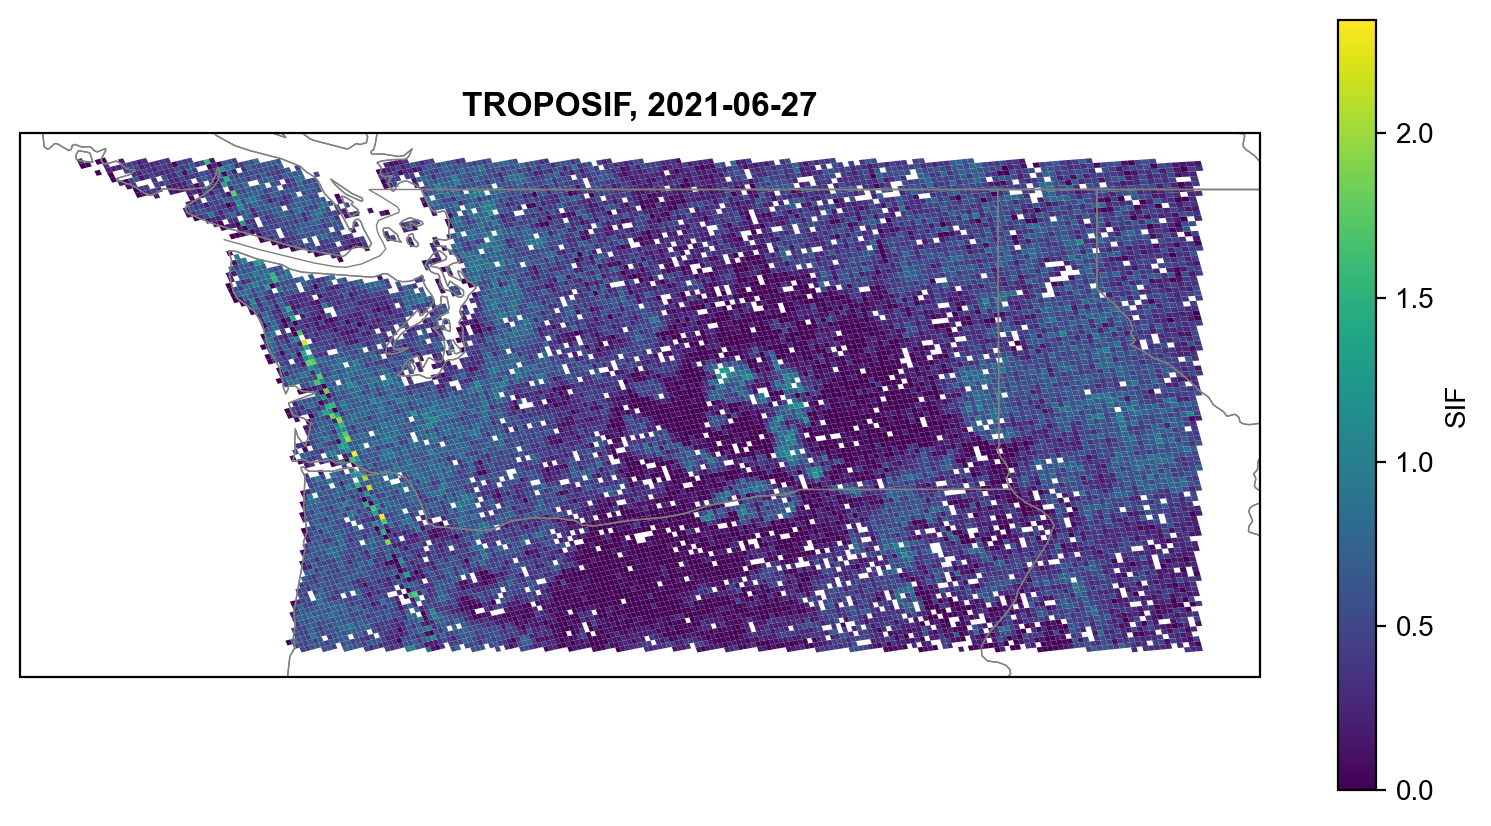

In [19]:
fig, ax = basemap()
im = gdf.plot('SIF_Corr_743', ax = ax, cmap = 'viridis', legend=True, vmin = 0, legend_kwds={"label": "SIF"})
ax.set_title("TROPOSIF, 2021-06-27", weight = 'bold');

---

# Method 2: Crude Regridding

In this particular implementation of regridding, we are going to take the **centroid** (midpoint) of each TROPOMI footprint and regrid it to our desired grid.

### For reference:

- descriptor: Used to specify a lon_min, lat_min, lon_max, lat_max for a bounding box, since TROPOMI datasets contain an entire global swath. Feel free to add or change any of the current descriptors in the if..elif statement at the bottom of the cell.
- data_type: the variable you want to process -- you may need to add code to reading_func if it is not specified in those functions!
- cell_size_lat, cell_size_lon: the desired cell size (in degrees) of the resulting grid

In [13]:
data_type = 'SIF' # Specifies methane!
prefix = '/home/disk/hermes/jyyoon/TROPOSIF'
geolocation_bounds = [-127.045898,42.098222,-112.478027,49.196064] # [-132.099609,46.709736,-121.420898,50.485474] # in [lon_min, lat_min, lon_max, lat_max], if you want an entire scanline, remove bounds = geolocation_bounds in the function call below or set this to 0

# Parameters that define our desired grid
cell_size_lat = 0.1
cell_size_lon = 0.1

# year_num = np.array([2019,2020,2021,2022,2023]) # Specify the years of interest.
# month_num = np.arange(1,13,1) # Specify the months (by number, e.g. January = 1)
# day_num = np.arange(1,32,1) # Specify a Numpy array with all of the dates in ascending order.

year_num = np.array([2021]) # Specify the years of interest.
month_num = np.array([6]) # Specify the months (by number, e.g. January = 1)
day_num = np.array([27]) # Specify a Numpy array with all of the dates in ascending order.

years = convert_to_string(year_num, 'year');
months = convert_to_string(month_num, 'month');
dates = convert_to_string(day_num, 'day');

new_grid_interp = new_grid(geolocation_bounds[0], geolocation_bounds[1], geolocation_bounds[2], geolocation_bounds[3], cell_size_lat, cell_size_lon) # Creates new grid to interpolate onto.

In [14]:
ds = np.array([]) # Define variable in global scope

for year in years:
    for month in months:
        for day in dates:
            
            date_string = f"{year}-{month}-{day}";
            fns = glob(f"{prefix}/{year}/{month}/TROPOSIF_L2B_{year}-{month}-{day}*.nc") # Takes all the swath datasets corresponding to that day

            daily_df = pd.DataFrame() # Stores daily data
            regridded_daily_df = pd.DataFrame() # Stores regridded daily data -- set blank just in case
            
            for fn in fns:
                df_i = read_scattered_TROPOMI_data(fn, data_type, bounds = geolocation_bounds)
                
                if (len(daily_df) == 0) & (len(df_i) > 0):
                    daily_df = df_i
                    
                elif (len(df_i) > 0):
                    daily_df = pd.concat([daily_df, df_i], axis = 0)
            
            # If there is data on that day, regrid!
            if len(daily_df) > 0: 
                regridded_daily_df = regrid_scattered_data(daily_df[['SIF_Corr_743', 'SIF_Corr_735', 'SIF_743', 'SIF_735', 'geometry']], new_grid_interp, data_type);
    
                regridded_daily_df['time'] = pd.to_datetime(date_string);
                regridded_daily_df = regridded_daily_df.set_index(['time', 'lat', 'lon']).to_xarray()
    
            # regridded_daily_df.to_netcdf(f"TROPOSIF_{year}{month}{day}.nc");

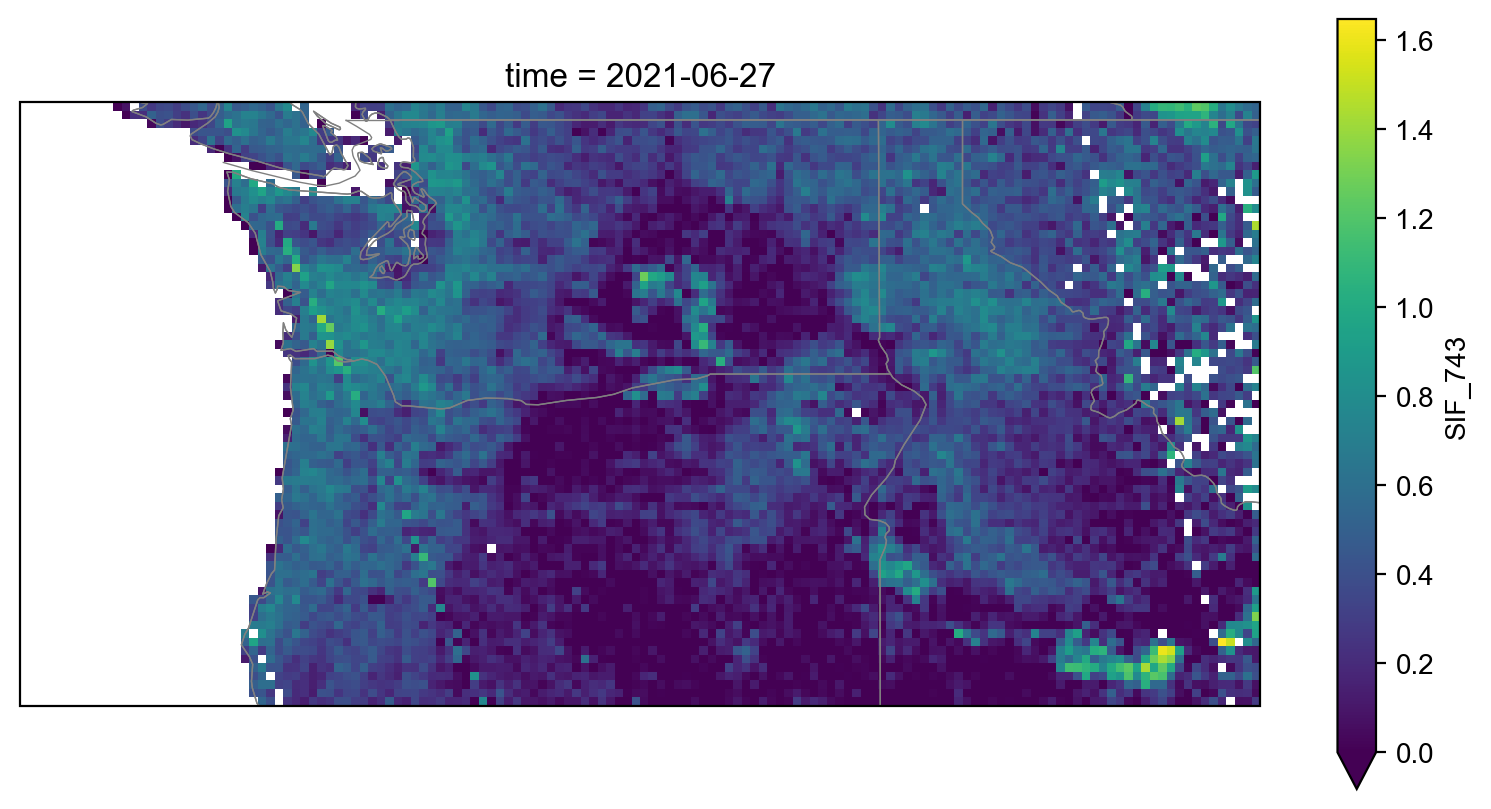

In [18]:
fig, ax = basemap()
regridded_daily_df.SIF_743.plot(ax = ax, transform = ccrs.PlateCarree(), cmap = 'viridis', vmin = 0)

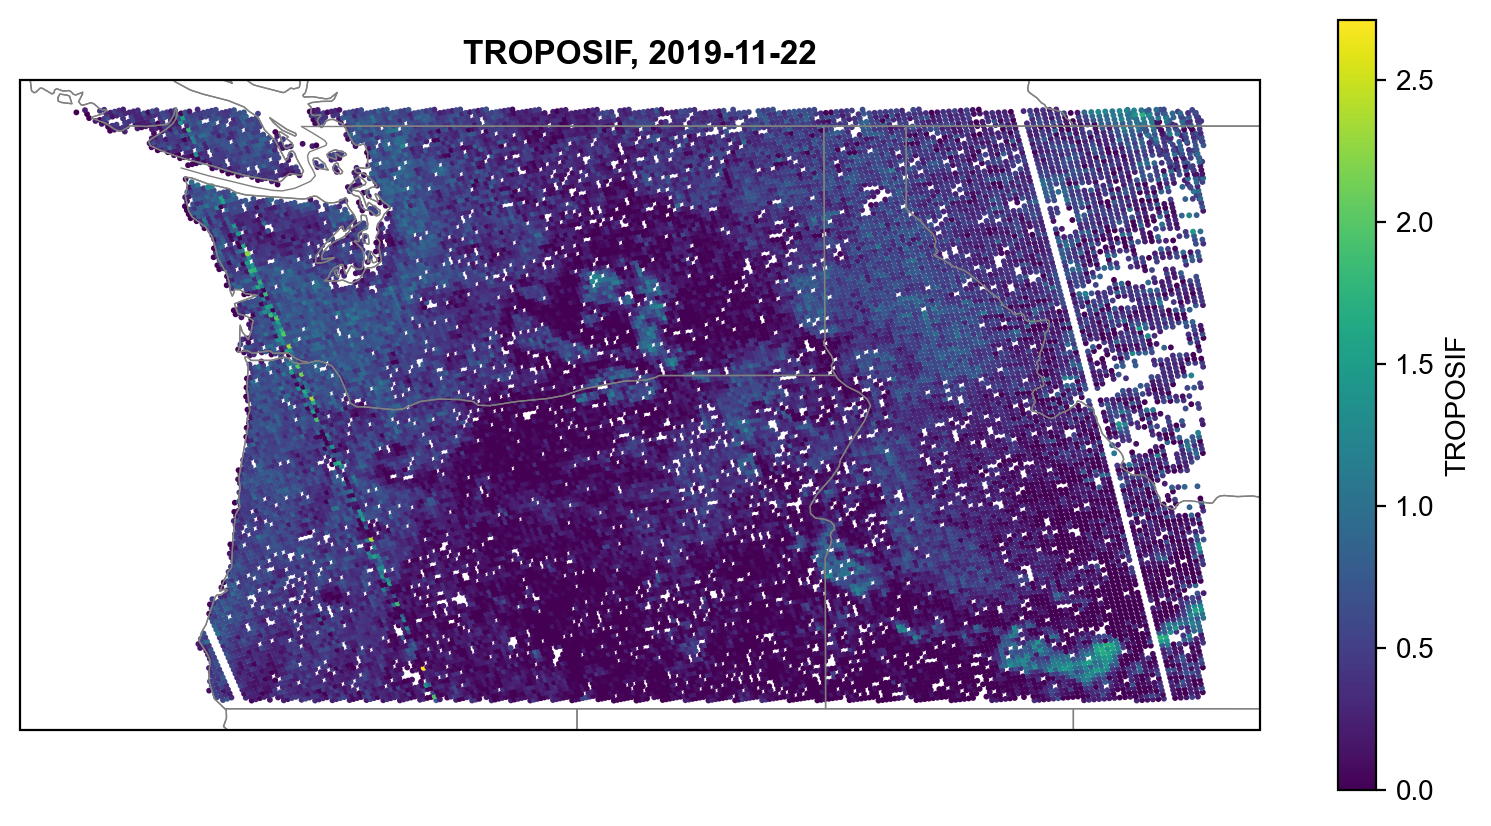

In [17]:
fig, ax = basemap()
im = daily_df.plot('SIF_Corr_743', ax = ax, cmap = 'viridis', vmin = 0, s = 1.2, legend=True,  legend_kwds={"label": "TROPOSIF"})
ax.set_title("TROPOSIF, 2019-11-22", weight = 'bold');